# Computing Particle Exit Angles

The goal of this code is the explore the directionality of gas particles exiting satellites. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle

mpl.rc('font',**{'family':'serif','monospace':['Palatino']})
mpl.rc('text', usetex=True)
plt.rcParams['figure.constrained_layout.use'] = False
mpl.rcParams.update({'font.size': 9})

age = 13.800797497330507

We will begin by exploring the galaxy `h242_24`. First we load in the data.

In [3]:
key = 'h148_13'
path = '../../Data/tracked_particles.hdf5'
data = pd.read_hdf(path, key=key)
data

# Temporary code to fix classification issue 
# (forgot to exclude disk particles from the halo in particletracking.py, so some were being classified in both)

data = data.rename(columns={'sat_disk': 'sat_disk_wrong',
                            'host_disk': 'host_disk_wrong',
                            'sat_halo': 'sat_halo_wrong',
                            'host_halo': 'host_halo_wrong'})

data['sat_disk'] = (data.rho >= 0.1) & (data.temp <= 1.2e4) & (data.r <= 3)
data['sat_halo'] = (data.r_per_Rvir < 1) & ~data.sat_disk
data['host_disk'] = (data.rho >= 0.1) & (data.temp <= 1.2e4) & (data.r_per_Rvir > 1) & (data.h1dist < 0.1)
data['host_halo'] = (data.r_per_Rvir > 1) & (data.h1dist < 1) & ~data.host_disk

data

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,sat_disk_wrong,sat_halo_wrong,IGM,host_halo_wrong,host_disk_wrong,classification,sat_disk,sat_halo,host_disk,host_halo
0,6.474131,2202002,0.000050,619653.812500,27934.820603,1.502397,315.430011,4.000096,301.379304,38.695749,...,False,False,False,True,False,4.0,False,False,False,True
1,6.474131,2205223,0.000034,246611.796875,26567.141174,0.000000,345.770111,4.384851,283.107089,38.728024,...,False,False,False,True,False,4.0,False,False,False,True
2,6.474131,2857672,0.000074,708055.187500,26511.576364,0.000000,373.134629,4.731871,360.627617,-35.282347,...,False,False,False,True,False,4.0,False,False,False,True
3,6.474131,4057198,0.000023,405099.468750,26510.536704,0.000000,593.153339,7.522018,563.303480,-183.727503,...,False,False,False,True,False,4.0,False,False,False,True
4,6.474131,4073949,0.000024,405991.656250,26510.536704,0.000000,588.527236,7.463352,556.331718,-188.298945,...,False,False,False,True,False,4.0,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12447,13.800797,19009255,0.478361,733.537537,30288.071656,13.796250,284.462060,4.318511,49.714790,250.171752,...,False,False,False,True,True,4.0,False,False,True,False
12448,13.800797,19078060,0.000206,840771.562500,26645.618222,8.779381,390.337777,5.925844,67.699234,345.184330,...,False,False,False,True,False,4.0,False,False,False,True
12449,13.800797,19100998,0.000036,204305.203125,26859.950488,8.804634,85.520235,1.298310,-53.786871,36.639670,...,False,False,False,True,False,4.0,False,False,False,True
12450,13.800797,19103645,0.000005,238948.421875,28078.179678,11.644720,154.169322,2.340494,129.548087,-47.754756,...,False,False,False,True,False,4.0,False,False,False,True


Then we need to identify the gas particles that have "just left" the satellite. First, I define this as a gas particle that was identified as part of the satellite halo in one snapshot (within the virial radius) and identified as part of the host halo in the subsequent snapshot. As usual, I compute this by looping through unique particle IDs, since some particles get lost in the tracking and this the only way to do this analysis robustly. 

The code produces a DataFrame, `just_left1`, which contains the properties of all particles that experience this transfer of state, at the subsequent snapshot. 

I then repeat the same code but identifying gas particles that are ejected from the *disk* of the satellite, i.e. those that are identified as part of the satellite disk in one snapshot and identified as part of the satellite halo in the next. 

In [4]:
import tqdm

just_left1 = pd.DataFrame()
just_left2 = pd.DataFrame()
prior_to_leaving1 = pd.DataFrame()
prior_to_leaving2 = pd.DataFrame()

pids = np.unique(data.pid)
for pid in tqdm.tqdm(pids):
    dat = data[data.pid==pid]

    sat_disk = np.array(dat.sat_disk, dtype=bool)
    sat_halo = np.array(dat.sat_halo, dtype=bool)
    host_halo = np.array(dat.host_halo,dtype=bool)
    time = np.array(dat.time,dtype=float)

    assert len(sat_disk) == len(sat_halo) == len(host_halo) == len(time)

    for t1,t2,sh1,hh2,sd1,sh2 in zip(time[:-1], time[1:], sat_halo[:-1], host_halo[1:], sat_disk[:-1], sat_halo[1:]):
        if sh1 and hh2:
            just_left1 = pd.concat([just_left1,dat[time==t2]])
            prior_to_leaving1 = pd.concat([prior_to_leaving1, dat[time==t1]])
        if sd1 and sh2:
            just_left2 = pd.concat([just_left2,dat[time==t2]])
            prior_to_leaving2 = pd.concat([prior_to_leaving2, dat[time==t1]])

100%|██████████| 14729/14729 [02:20<00:00, 104.89it/s]


Next we need to compute the angle between the particle velocity vectors (measured in the rest frame of the satellite) and the bulk host velocity (measured in the rest frame of the satellite). The latter acts as a proxy for the CGM wind velocity, which we could compute more directly by identifying the gas particles that make up the CGM wind. 

If the exit angle (angle between these vectors) is generally around 0, then we know that the particles are generally moving the same direction as the CGM relative to the satellite, a clear signature of ram pressure stripping. If the angle is more uniformly distributed, the particles are leaving in every direction, a more clear signature of feedback or tidal stripping. If we see a double-peaked distribution, that would be a clear signature of tidal stripping. 

In [5]:
angles1 = np.array([])

for d in tqdm.tqdm(just_left1.iterrows()):
    # get gas particle velocity
    v = np.array([d[1].vx,d[1].vy,d[1].vz])
    
    # get velocity of CGM wind (host velocity relative to satellite)
    v_sat = np.array([d[1].sat_vx,d[1].sat_vy,d[1].sat_vz])
    v_host = np.array([d[1].host_vx,d[1].host_vy,d[1].host_vz])
    v_rel = v_host - v_sat # we want the velocity of the host in the satellite rest frame
    
    # take the dot product and get the angle, in degrees
    v_hat = v / np.linalg.norm(v)
    v_rel_hat = v_rel / np.linalg.norm(v_rel)
    angle = np.arccos(np.dot(v_hat,v_rel_hat)) * 180/np.pi
    angles1 = np.append(angles1,angle)
    
angles2 = np.array([])

for d in tqdm.tqdm(just_left2.iterrows()):
    v = np.array([d[1].vx,d[1].vy,d[1].vz])
    
    v_sat = np.array([d[1].sat_vx,d[1].sat_vy,d[1].sat_vz])
    v_host = np.array([d[1].host_vx,d[1].host_vy,d[1].host_vz])
    v_rel = v_host - v_sat 
    
    v_hat = v / np.linalg.norm(v)
    v_rel_hat = v_rel / np.linalg.norm(v_rel)
    angle = np.arccos(np.dot(v_hat,v_rel_hat)) * 180/np.pi
    angles2 = np.append(angles2,angle)

13938it [00:02, 5881.86it/s]
9633it [00:01, 5872.61it/s]


This next bit is somewhat complicated, and it took me a while to realize that it was necessary. In order to represent the distribution of exit angles, we need to bin the data in bins of unequal size. This is because the angle we have calculated is effectively the colatitude of the sphere, or $\theta$ in spherical coordinates. The part of the sphere with $\theta \approx 90^\circ$ (the equator) is much larger in area than the part of the sphere with $\theta \approx 0^\circ$ or $\theta \approx 180^\circ$ (the poles). That is, we are bound to see a lot more particles exit with $\theta$ near $90^\circ$ than at the poles, as there is more area at which they can exit. 

In a closer read of Bahé et al. (2015), I realized that they bin the data into "20 bins of equal solid angle," such that if the distribution of $\theta$ was perfectly random, each bin would have 5% of the distribution. We do the same here. 

The total solid angle bounded by two colatitude angles $\theta_1$ and $\theta_2$ is given by 
$$\Omega = \iint_S \sin\theta\,d\theta\,d\phi = 2\pi \int_{\theta_1}^{\theta_2} \sin\theta\,d\theta = 2\pi~\left[-\cos\theta_2 + \cos\theta_1\right]$$
Since the entire sphere has solid angle of $\Omega = 4\pi$, if we want $N$ bins total then we need to construct our bins such that each one has solid angle $4\pi/N$. Thus,
$$\frac{4\pi}{N} = 2\pi~[\cos\theta_1 - \cos\theta_2]$$
$$2\pi \cos\theta_2 = 2\pi\cos\theta_1 - \frac{4\pi}{N}$$
$$\theta_2 = \arccos\left( \cos\theta_1 - \frac{2}{N} \right)$$
We construct our bins iteratively using this equation under a loop:

In [6]:
N = 50 # more bins than Bahé et al since we have lots of particles
theta1,theta2 = 0,0 # initialize
bins = np.array([theta1]) 
while theta2 < 3.14:
    theta2 = np.arccos(np.cos(theta1)-(2/N))
    bins = np.append(bins,theta2)
    theta1 = theta2

bins = bins*180/np.pi
bincenters = 0.5*(bins[1:]+bins[:-1])
print(bins)

[  0.          16.26020471  23.07391807  28.35763658  32.85988038
  36.86989765  40.53580211  43.94551956  47.15635696  50.2081805
  53.13010235  55.94420226  58.6677485   61.31459799  63.89611886
  66.42182152  68.89980398  71.33707512  73.73979529  76.11345964
  78.46304097  80.79310378  83.10789742  85.41143426  87.70755722
  90.          92.29244278  94.58856574  96.89210258  99.20689622
 101.53695903 103.88654036 106.26020471 108.66292488 111.10019602
 113.57817848 116.10388114 118.68540201 121.3322515  124.05579774
 126.86989765 129.7918195  132.84364304 136.05448044 139.46419789
 143.13010235 147.14011962 151.64236342 156.92608193 163.73979529
 179.99999774]


Now that we have our bins, we also need to consider weighting our data. While most of our gas particles are the same  mass, it is more robust to weight by particle mass, and also aids in the interpretation of the histogram, as we can interpret the $y$-axis as the fraction of the total gas mass ejected that is ejected at that angle of $\theta$. We construct our weights as:

In [297]:
mass1 = np.array(just_left1.mass)
weights1 = mass1/mass1.sum()

mass2 = np.array(just_left2.mass)
weights2 = mass2/mass2.sum()

It is now time to construct our plot!

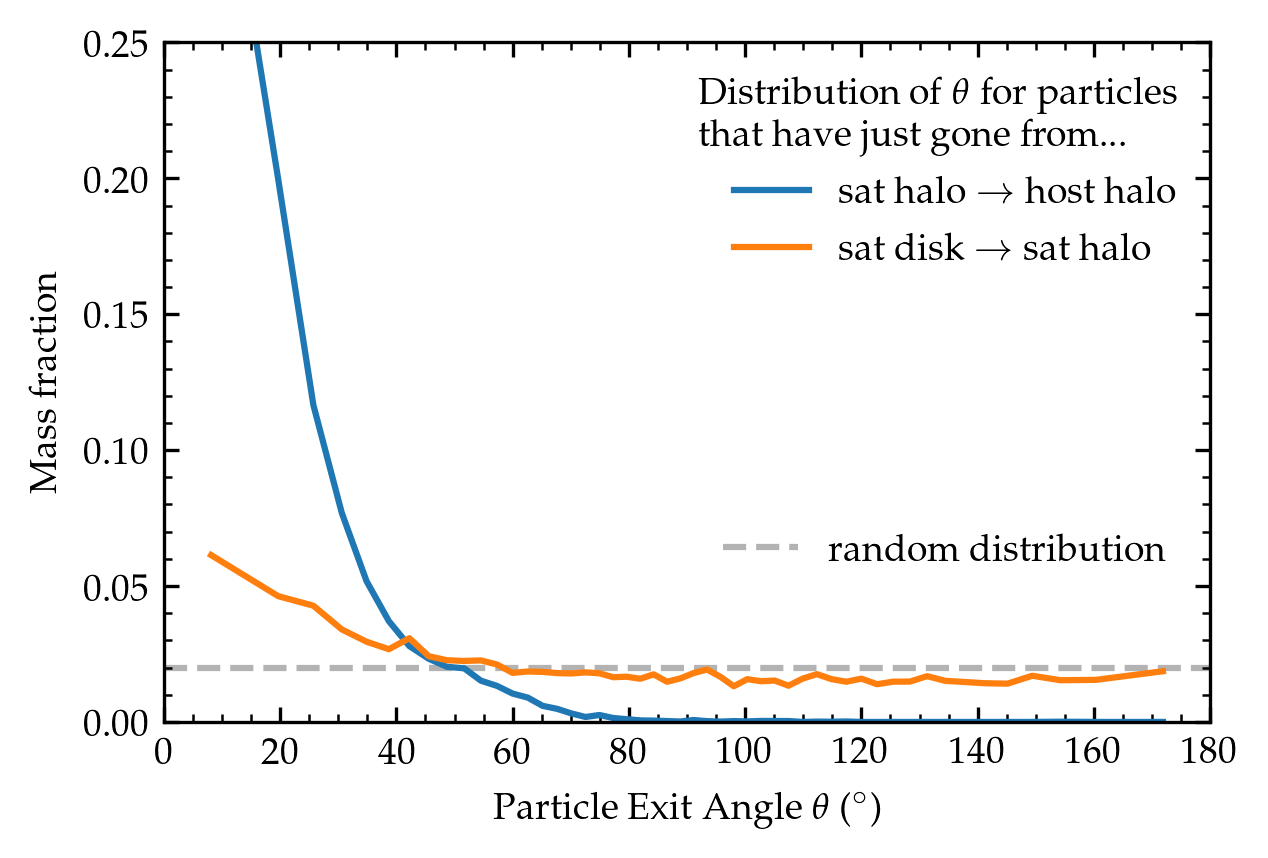

In [208]:
fig, ax = plt.subplots(1,1,dpi=300, figsize=(4.5,3))

# plot the two distributions
y1, bins = np.histogram(angles1, bins=bins, weights=weights1)
l1 = r'sat halo $\to$ host halo'
p1, = ax.plot(bincenters, y1, label=l1)
y2, bins = np.histogram(angles2, bins=bins, weights=weights2)
l2 = r'sat disk $\to$ sat halo'
p2, = ax.plot(bincenters, y2, label=l2)

# plot the line that represents a random distribution
percent = 1/N
p3, = ax.plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1)

# add legends
leg1 = ax.legend([p1,p2],[l1,l2],title=r'Distribution of $\theta$ for'+' particles\n that have just gone from...', frameon=False)
leg1._legend_box.align = 'right'
leg2 = ax.legend([p3],['random distribution'], frameon=False, loc=(0.52,0.2))
ax.add_artist(leg1)

# labels and ticks and such
ax.set_xlabel(r'Particle Exit Angle $\theta$ ($^\circ$)')
ax.set_ylabel('Mass fraction')
ax.set_xlim(0,180)
ax.set_ylim(0,0.25)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))
ax.tick_params(direction='in',which='both',right=True,top=True)

plt.show()

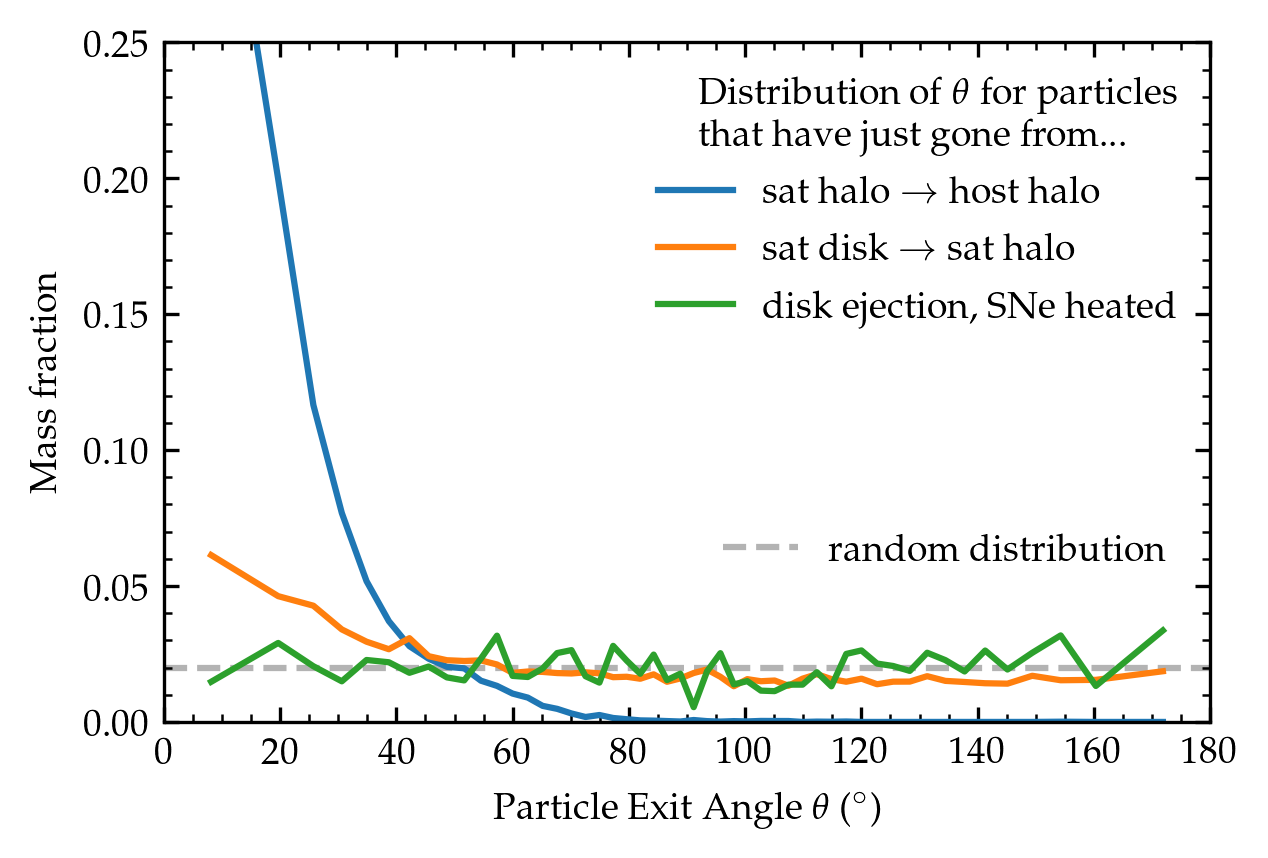

In [298]:
fig, ax = plt.subplots(1,1,dpi=300, figsize=(4.5,3))

# plot the two distributions
y1, bins = np.histogram(angles1, bins=bins, weights=weights1)
l1 = r'sat halo $\to$ host halo'
p1, = ax.plot(bincenters, y1, label=l1)
y2, bins = np.histogram(angles2, bins=bins, weights=weights2)
l2 = r'sat disk $\to$ sat halo'
p2, = ax.plot(bincenters, y2, label=l2)

cond = just_left2.coolontime > just_left2.time
y3, bins = np.histogram(angles2[cond], bins=bins, weights=mass2[cond]/mass2[cond].sum())
l3 = r'disk ejection, SNe heated'
p3, = ax.plot(bincenters, y3, label=l3)

# plot the line that represents a random distribution
percent = 1/N
p4, = ax.plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1)

# add legends
leg1 = ax.legend([p1,p2,p3],[l1,l2,l3],title=r'Distribution of $\theta$ for'+' particles\n that have just gone from...', frameon=False)
leg1._legend_box.align = 'right'
leg2 = ax.legend([p4],['random distribution'], frameon=False, loc=(0.52,0.2))
ax.add_artist(leg1)

# labels and ticks and such
ax.set_xlabel(r'Particle Exit Angle $\theta$ ($^\circ$)')
ax.set_ylabel('Mass fraction')
ax.set_xlim(0,180)
ax.set_ylim(0,0.25)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))
ax.tick_params(direction='in',which='both',right=True,top=True)

plt.show()

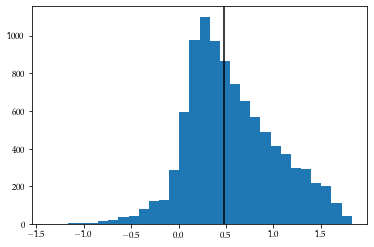

In [15]:
plt.hist(np.log10(just_left2.r), bins=30)
plt.axline((np.log10(3),0), (np.log10(3), 1000), color='k')
plt.show()

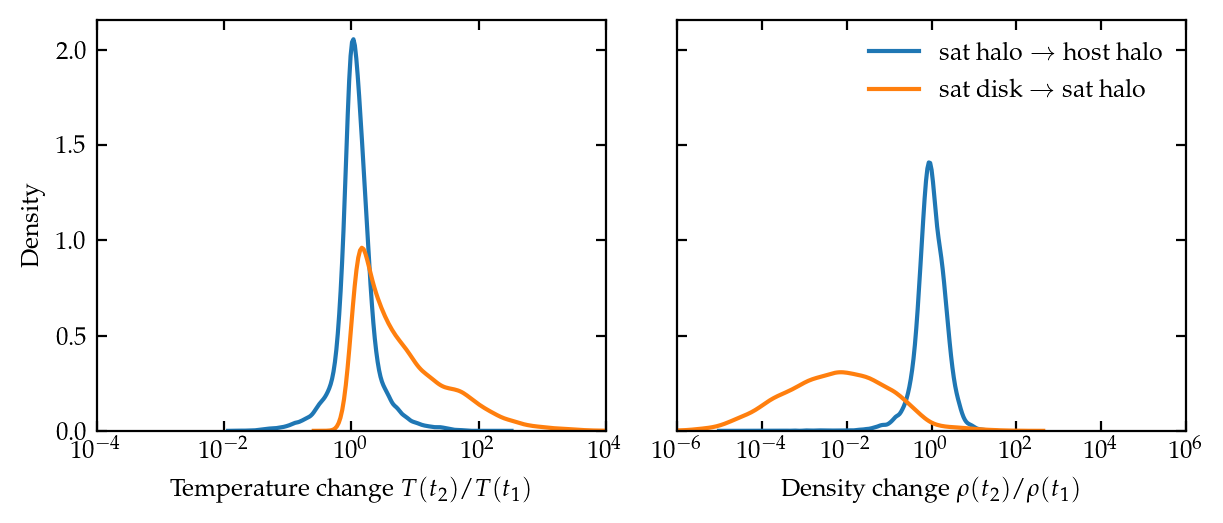

In [294]:
import seaborn as sns

fig, ax = plt.subplots(1,2, figsize=(6,2.5), dpi=200, sharey=True, constrained_layout=True)
sns.kdeplot(np.array(just_left1.temp)/np.array(prior_to_leaving1.temp), ax=ax[0], log_scale=True, label=r'sat halo $\to$ host halo')
sns.kdeplot(np.array(just_left2.temp)/np.array(prior_to_leaving2.temp), ax=ax[0], log_scale=True, label=r'sat disk $\to$ sat halo')
# sns.kdeplot(np.array(just_left2.temp/prior_to_leaving2.temp)[prior_to_leaving2.coolontime > prior_to_leaving2.time], 
#             ax=ax[0], color='tab:orange', linestyle='--', linewidth='1', log_scale=True, label=r'sat disk $\to$ sat halo')

ax[0].set_xlim(1e-4,1e4)
ax[0].set_xlabel(r'Temperature change $T(t_2)/T(t_1)$')

sns.kdeplot(np.array(just_left1.rho)/np.array(prior_to_leaving1.rho), ax=ax[1], log_scale=True, label=r'sat halo $\to$ host halo')
sns.kdeplot(np.array(just_left2.rho)/np.array(prior_to_leaving2.rho), ax=ax[1], log_scale=True, label=r'sat disk $\to$ sat halo')

ax[1].set_xlim(1e-6,1e6)
ax[1].set_xlabel(r'Density change $\rho(t_2)/\rho(t_1)$')
ax[1].legend(frameon=False)

ax[0].tick_params(direction='in',which='both',top=True,right=True)
ax[1].tick_params(direction='in',which='both',top=True,right=True)

plt.show()


The goal of this plot would be to distinguish between the two processes potentially leading to a random distribuition of exit angles. 

* The first, feedback, should increase the gas temperature while leaving the density alone.
* The second, tidal stripping, should not affect the temperature but may affect the density. 

We can see above that for halo gas ejected, there is generally no preference for an increase or decrease in either temperature or density. This makes sense, as ram pressure should not be able to significantly alter the state of the gas. The only documented thing I can think of is RP compacting gas and increasing the density, but that would probably not happen for the already hot/diffuse gas in the halo. 

For disk gas ejected, however, there is a strong preference for an increase in temperature and a decrease in density. However, the increase in temperature peaks close to 1, indicating that a lot of particles have little temperature change but have a change in density. This is a signature of tidal stripping. The temperature distribution is highly right-skewed, which indicates that there is likely feedback at play. 

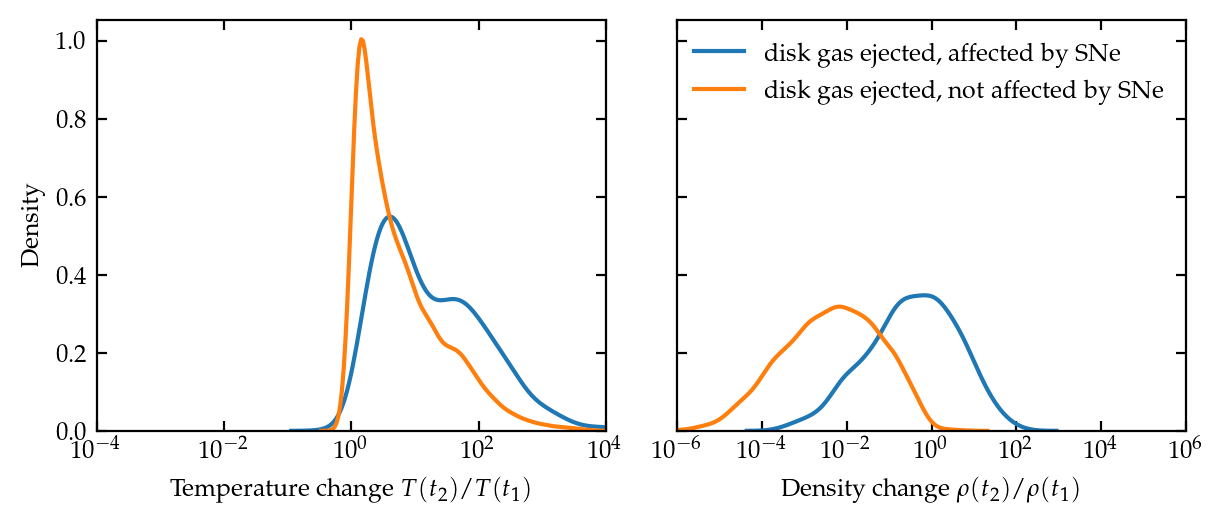

In [313]:
import seaborn as sns

fig, ax = plt.subplots(1,2, figsize=(6,2.5), dpi=200, sharey=True, constrained_layout=True)

cond =  just_left2.coolontime > just_left2.time

y = np.array(just_left2.temp)/np.array(prior_to_leaving2.temp)
sns.kdeplot(y[cond], ax=ax[0], log_scale=True, label=r'disk gas ejected, affected by SNe')
sns.kdeplot(y[~cond], ax=ax[0], log_scale=True, label=r'disk gas ejected, not affected by SNe')

ax[0].set_xlim(1e-4,1e4)
ax[0].set_xlabel(r'Temperature change $T(t_2)/T(t_1)$')

y = np.array(just_left2.rho)/np.array(prior_to_leaving2.rho)
sns.kdeplot(y[cond], ax=ax[1], log_scale=True, label=r'disk gas ejected, affected by SNe')
sns.kdeplot(y[~cond], ax=ax[1], log_scale=True, label=r'disk gas ejected, not affected by SNe')

ax[1].set_xlim(1e-6,1e6)
ax[1].set_xlabel(r'Density change $\rho(t_2)/\rho(t_1)$')
ax[1].legend(frameon=False)

ax[0].tick_params(direction='in',which='both',top=True,right=True)
ax[1].tick_params(direction='in',which='both',top=True,right=True)

plt.show()


In [243]:
cond = np.array(prior_to_leaving2.coolontime > prior_to_leaving2.time)
np.array(just_left2.temp/prior_to_leaving2.temp)

array([ 6.0639922 , 92.58289303,  1.89912656, ...,         nan,
               nan,         nan])

array([ 6.0639922 , 28.99519409,  6.7371653 , ...,  1.41617235,
       10.45133422,  3.44277702])

## Scaling up to multiple satellites

In [127]:
keys = ['h242_24', 'h148_13', 'h148_28', 'h148_37', 'h148_68', 'h229_20', 'h229_22', 'h242_80']
path = '../../Data/tracked_particles.hdf5'

data = pd.DataFrame()

for key in keys:
    d = pd.read_hdf(path, key=key)
    d['key'] = key
    data = pd.concat([data,d])

# Temporary code to fix classification issue 
# (forgot to exclude disk particles from the halo in particletracking.py, so some were being classified in both)

data = data.rename(columns={'sat_disk': 'sat_disk_wrong',
                            'host_disk': 'host_disk_wrong',
                            'sat_halo': 'sat_halo_wrong',
                            'host_halo': 'host_halo_wrong'})

data['sat_disk'] = (data.rho >= 0.1) & (data.temp <= 1.2e4) & (data.r <= 3)
data['sat_halo'] = (data.r_per_Rvir < 1) & ~data.sat_disk
data['host_disk'] = (data.rho >= 0.1) & (data.temp <= 1.2e4) & (data.r_per_Rvir > 1) & (data.h1dist < 0.1)
data['host_halo'] = (data.r_per_Rvir > 1) & (data.h1dist < 1) & ~data.host_disk

data

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,sat_halo_wrong,IGM,host_halo_wrong,host_disk_wrong,classification,key,sat_disk,sat_halo,host_disk,host_halo
0,5.181190,811077,0.000037,5.369499e+05,26510.536704,0.000000,317.229043,5.719189,-173.390813,23.552462,...,False,False,True,False,4.0,h242_24,False,False,False,True
1,5.181190,6872943,0.000560,1.621470e+06,33820.435130,4.999814,305.111904,5.500734,-149.748558,152.158116,...,False,False,True,False,4.0,h242_24,False,False,False,True
2,5.181190,8840402,0.000179,6.317682e+04,26510.536704,0.000000,352.882340,6.361967,133.276947,199.077824,...,False,True,False,False,5.0,h242_24,False,False,False,False
3,5.181190,8987571,0.000017,2.664518e+05,26510.536704,0.000000,26.778647,0.482781,-9.585453,-3.929157,...,True,False,False,False,2.0,h242_24,False,True,False,False
4,5.181190,9655109,0.000078,1.011527e+05,26510.536704,0.000000,16.040076,0.289180,-2.434631,-11.577726,...,True,False,False,False,2.0,h242_24,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12737,13.800797,10298301,0.056452,5.618703e+03,28948.967330,13.774364,135.163190,4.521191,-85.458108,-4.623048,...,False,False,True,False,4.0,h242_80,False,False,False,True
12738,13.800797,10308180,0.000792,1.401448e+04,26525.756840,0.000000,26.956771,0.901700,-8.969144,-2.847575,...,True,False,False,False,2.0,h242_80,False,True,False,False
12739,13.800797,10415354,0.166512,5.064715e+03,26714.441286,13.602646,131.291563,4.391685,-51.422925,-36.670975,...,False,False,True,False,4.0,h242_80,False,False,False,True
12740,13.800797,10533119,0.002758,2.248430e+06,27211.947879,13.756687,134.156683,4.487523,-81.826323,-4.631989,...,False,False,True,False,4.0,h242_80,False,False,False,True


In [138]:
import tqdm

just_left1 = pd.DataFrame()
just_left2 = pd.DataFrame()

for key in keys:
    dat1 = data[data.key==key]
    pids = np.unique(dat1.pid)
    for pid in tqdm.tqdm(pids):
        dat = dat1[dat1.pid==pid]

        sat_disk = np.array(dat.sat_disk, dtype=bool)
        sat_halo = np.array(dat.sat_halo, dtype=bool)
        host_halo = np.array(dat.host_halo,dtype=bool)
        time = np.array(dat.time,dtype=float)

        assert len(sat_disk) == len(sat_halo) == len(host_halo) == len(time)

        for t,sh1,hh2,sd1,sh2 in zip(time[1:], sat_halo[:-1], host_halo[1:], sat_disk[:-1], sat_halo[1:]):
            if sh1 and hh2:
                just_left1 = pd.concat([just_left1,dat[time==t]])
            if sd1 and sh2:
                just_left2 = pd.concat([just_left2,dat[time==t]])

100%|██████████| 12766/12766 [29:04<00:00,  7.32it/s]


In [141]:
angles1 = np.array([])

for d in tqdm.tqdm(just_left1.iterrows()):
    # get gas particle velocity
    v = np.array([d[1].vx,d[1].vy,d[1].vz])
    
    # get velocity of CGM wind (host velocity relative to satellite)
    v_sat = np.array([d[1].sat_vx,d[1].sat_vy,d[1].sat_vz])
    v_host = np.array([d[1].host_vx,d[1].host_vy,d[1].host_vz])
    v_rel = v_host - v_sat # we want the velocity of the host in the satellite rest frame
    
    # take the dot product and get the angle, in degrees
    v_hat = v / np.linalg.norm(v)
    v_rel_hat = v_rel / np.linalg.norm(v_rel)
    angle = np.arccos(np.dot(v_hat,v_rel_hat)) * 180/np.pi
    angles1 = np.append(angles1,angle)
    
angles2 = np.array([])

for d in tqdm.tqdm(just_left2.iterrows()):
    v = np.array([d[1].vx,d[1].vy,d[1].vz])
    
    v_sat = np.array([d[1].sat_vx,d[1].sat_vy,d[1].sat_vz])
    v_host = np.array([d[1].host_vx,d[1].host_vy,d[1].host_vz])
    v_rel = v_host - v_sat 
    
    v_hat = v / np.linalg.norm(v)
    v_rel_hat = v_rel / np.linalg.norm(v_rel)
    angle = np.arccos(np.dot(v_hat,v_rel_hat)) * 180/np.pi
    angles2 = np.append(angles2,angle)

172878it [00:33, 5138.85it/s]
194555it [00:39, 4879.05it/s]


In [142]:
N = 50 # more bins than Bahé et al since we have lots of particles
theta1,theta2 = 0,0 # initialize
bins = np.array([theta1]) 
while theta2 < 3.14:
    theta2 = np.arccos(np.cos(theta1)-(2/N))
    bins = np.append(bins,theta2)
    theta1 = theta2

bins = bins*180/np.pi
bincenters = 0.5*(bins[1:]+bins[:-1])

In [173]:
mass1 = np.array(just_left1.mass)
weights1 = mass1/mass1.sum()

mass2 = np.array(just_left2.mass)
weights2 = mass2/mass2.sum()

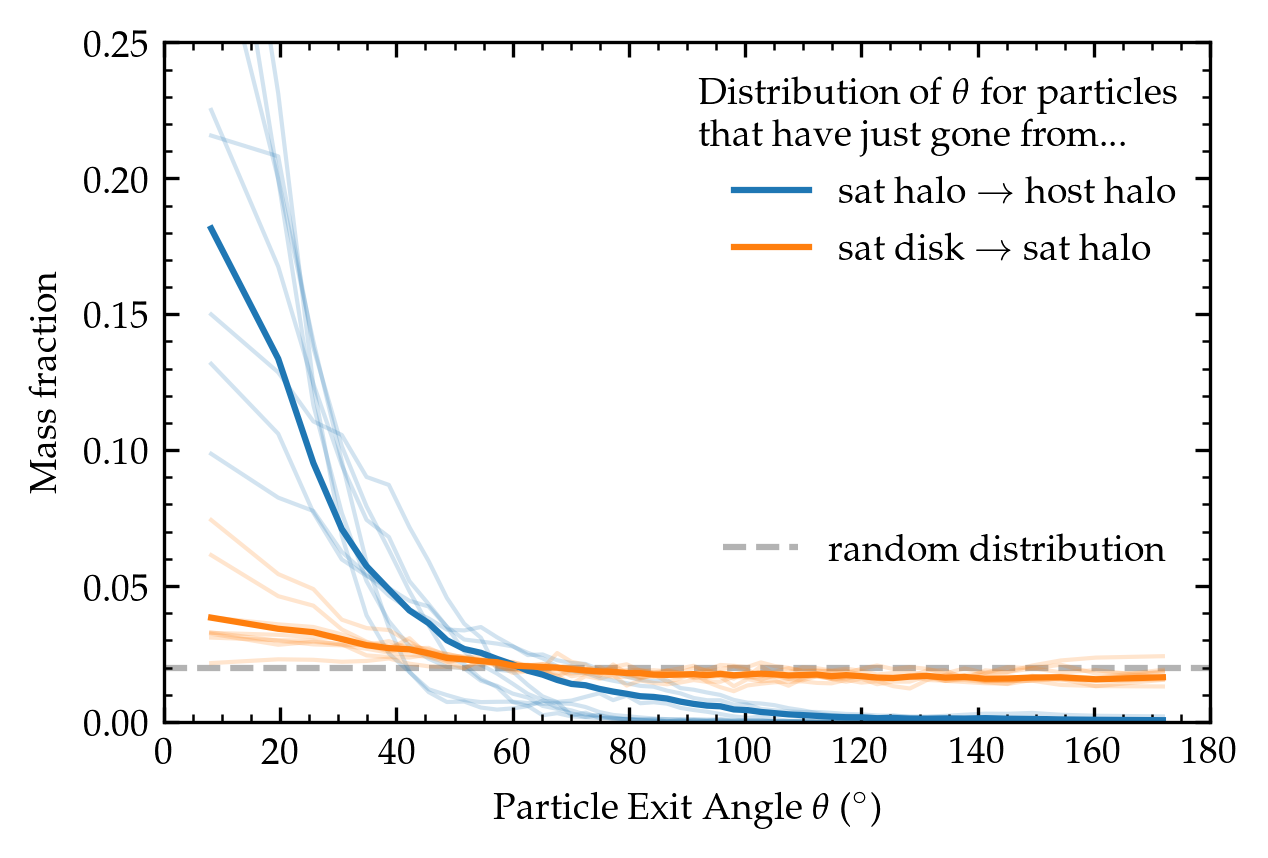

In [200]:
fig, ax = plt.subplots(1,1,dpi=300, figsize=(4.5,3))

# plot the two distributions
y1, bins = np.histogram(angles1, bins=bins, weights=weights1)
l1 = r'sat halo $\to$ host halo'
p1, = ax.plot(bincenters, y1, label=l1)
y2, bins = np.histogram(angles2, bins=bins, weights=weights2)
l2 = r'sat disk $\to$ sat halo'
p2, = ax.plot(bincenters, y2, label=l2)


for key in keys:
    cond = just_left1.key == key
    mass = np.array(just_left1.mass)[cond]
    weights = mass/mass.sum()
    y1, bins = np.histogram(angles1[cond], bins=bins, weights=weights)
    ax.plot(bincenters, y1, color='tab:blue', alpha=0.2, zorder=0, linewidth=1)
    
for key in keys:
    cond = just_left2.key == key
    mass = np.array(just_left2.mass)[cond]
    weights = mass/mass.sum()
    y2, bins = np.histogram(angles2[cond], bins=bins, weights=weights)
    ax.plot(bincenters, y2, color='tab:orange', alpha=0.2, zorder=0, linewidth=1)

# plot the line that represents a random distribution
percent = 1/N
p3, = ax.plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1)

# add legends
leg1 = ax.legend([p1,p2],[l1,l2],title=r'Distribution of $\theta$ for'+' particles\n that have just gone from...', frameon=False)
leg1._legend_box.align = 'right'
leg2 = ax.legend([p3],['random distribution'], frameon=False, loc=(0.52,0.2))
ax.add_artist(leg1)

# labels and ticks and such
ax.set_xlabel(r'Particle Exit Angle $\theta$ ($^\circ$)')
ax.set_ylabel('Mass fraction')
ax.set_xlim(0,180)
ax.set_ylim(0,0.25)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))
ax.tick_params(direction='in',which='both',right=True,top=True)

plt.savefig('plots/theta_allsats.pdf')
plt.show()

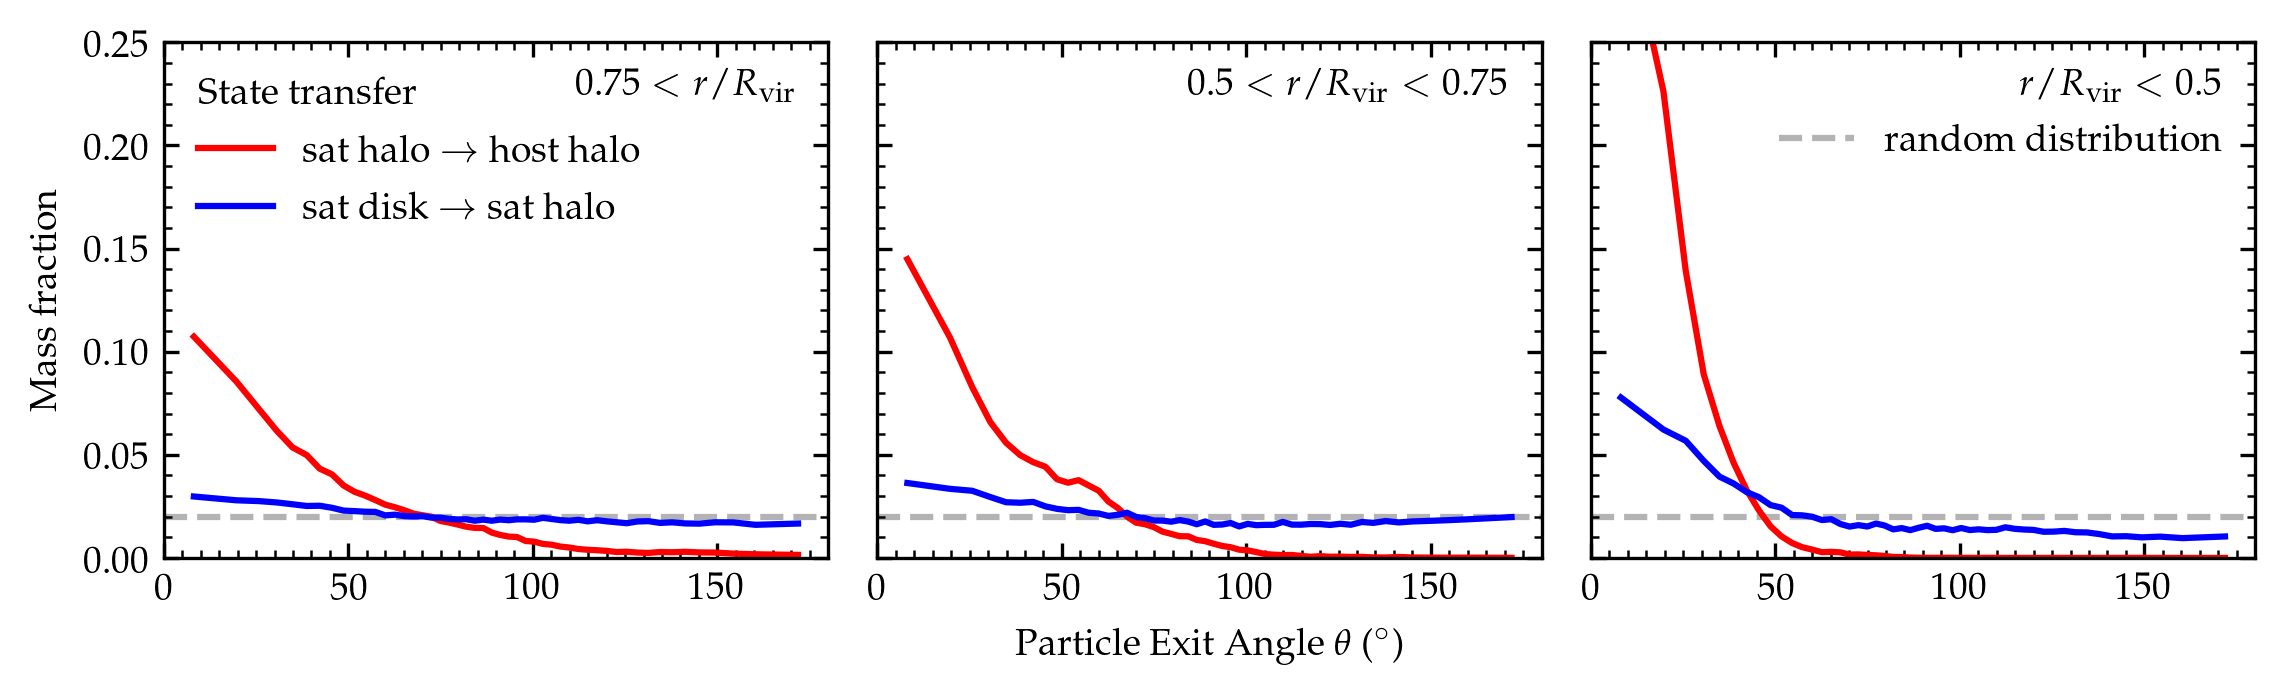

In [201]:
sat_pos = np.array([np.array(just_left1.sat_Xc), np.array(just_left1.sat_Yc), np.array(just_left1.sat_Zc)]).T
host_pos = np.array([np.array(just_left1.host_Xc), np.array(just_left1.host_Yc), np.array(just_left1.host_Zc)]).T
pos_rel = (sat_pos - host_pos) 
pos_mag1 = np.sqrt(pos_rel[:,0]**2 + pos_rel[:,1]**2 + pos_rel[:,2]**2)
pos_mag1 /= np.array(just_left1.h1Rvir)

sat_pos = np.array([np.array(just_left2.sat_Xc), np.array(just_left2.sat_Yc), np.array(just_left2.sat_Zc)]).T
host_pos = np.array([np.array(just_left2.host_Xc), np.array(just_left2.host_Yc), np.array(just_left2.host_Zc)]).T
pos_rel = (sat_pos - host_pos) 
pos_mag2 = np.sqrt(pos_rel[:,0]**2 + pos_rel[:,1]**2 + pos_rel[:,2]**2)
pos_mag2 /= np.array(just_left2.h1Rvir)


fig,ax = plt.subplots(1,3, dpi=300, figsize=(7.5,2.2), sharey=True, constrained_layout=True)

# leftmost ax will be r > 0.75
ax[0].annotate(r'$0.75 < r/R_{\rm vir}$',(0.95,0.95),xycoords='axes fraction',ha='right',va='top')
cond = pos_mag1 >= 0.75
y1, bins = np.histogram(angles1[cond], bins=bins, weights=mass1[cond]/np.sum(mass1[cond]))
l1 = r'sat halo $\to$ host halo'
ax[0].plot(bincenters, y1, label=l1, color='r')

cond = pos_mag2 > 0.75
y2, bins = np.histogram(angles2[cond], bins=bins, weights=mass2[cond]/np.sum(mass2[cond]))
l2 = r'sat disk $\to$ sat halo'
ax[0].plot(bincenters, y2, label=l2, color='b')


# middle ax will be 0.5 < r < 0.75
ax[1].annotate(r'$0.5 < r/R_{\rm vir} < 0.75$',(0.95,0.95),xycoords='axes fraction',ha='right',va='top')
cond = (pos_mag1 >= 0.5) & (pos_mag1 < 0.75)
y1, bins = np.histogram(angles1[cond], bins=bins, weights=mass1[cond]/np.sum(mass1[cond]))
ax[1].plot(bincenters, y1, color='r')

cond = (pos_mag2 >= 0.5) & (pos_mag2 < 0.75)
y2, bins = np.histogram(angles2[cond], bins=bins, weights=mass2[cond]/np.sum(mass2[cond]))
ax[1].plot(bincenters, y2, color='b')


# rightmost ax will be r < 0.5
ax[2].annotate(r'$r/R_{\rm vir} < 0.5$',(0.95,0.95),xycoords='axes fraction',ha='right',va='top')
cond = pos_mag1 < 0.5
y1, bins = np.histogram(angles1[cond], bins=bins, weights=mass1[cond]/np.sum(mass1[cond]))
ax[2].plot(bincenters, y1, color='r')

cond = pos_mag2 < 0.5
y2, bins = np.histogram(angles2[cond], bins=bins, weights=mass2[cond]/np.sum(mass2[cond]))
ax[2].plot(bincenters, y2, color='b')


# plot the line that represents a random distribution
percent = 1/N
ax[0].plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1)
ax[1].plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1)
ax[2].plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1, label='random distribution')

# add legends
leg1 = ax[0].legend(title=r'State transfer', frameon=False, loc='upper left')
leg1._legend_box.align = 'left'
ax[2].legend(frameon=False, loc=(0.26,0.74))

# labels and ticks and such
ax[1].set_xlabel(r'Particle Exit Angle $\theta$ ($^\circ$)')
ax[0].set_ylabel('Mass fraction')
for a in ax:
    a.set_xlim(0,180)
    a.set_ylim(0,0.25)

    a.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
    a.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))
    a.tick_params(direction='in',which='both',right=True,top=True)

# plt.savefig('plots/theta_allsats_byR.pdf')
plt.show()

Dominated by one satellite?

Mass effect? Lower mass galaxies will have weaker restoring forces, will we see more stripping of disk gas?

Higher mass satellites, disk gas is protected from RPS for larger fractions of the orbit. 

Distinct effect from potential well vs. gas reservoir

Set up a separate script to calculate ram pressure as a function of time.

Tracking stars as well?

Other things to look at: 
temperature/density of gas as it is lost? 

to distinguish between the processes affecting the disk

*feedback*: start of at high density, low temperature and then high temperature/high density after removal

RPS: high temperature, low density gas is most easily removed

tidal stripping should have no affect or preference on temperature, might affect the density

*make orbit plots with gas temperature and density, looking at ram pressure over time and comparing to orbital dynamics*

spherically averaged density profile vs. local CGM density

more robust way: picking up gas that is leaving the satellite? 
maybe do it only for gas particles that have not yet been in the satellite? 

need to do a comparison between these two methods